In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm import tqdm


PROCESSED_DATA = os.path.join("data", "processed-data")


In [5]:

# File paths
btc_processed_file = os.path.join(PROCESSED_DATA, "btc_1min_processed.csv.gz")
eth_processed_file = os.path.join(PROCESSED_DATA, "eth_1min_processed.csv.gz")
combined_file      = os.path.join(PROCESSED_DATA, "crypto_1min_combined.csv.gz")
NEWS_FILTERED_CSV  = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")

# Read the processed CSV files using gzip compression
btc_df = pd.read_csv(btc_processed_file, compression="gzip")
eth_df = pd.read_csv(eth_processed_file, compression="gzip")
crypto_df = pd.read_csv(combined_file, compression="gzip")
df_filtered_news = pd.read_csv(NEWS_FILTERED_CSV, compression="gzip")


In [ ]:

def prepare_df(df):

    # Convert 'Date' to datetime & drop NaNs
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True)
    
    # Set and sort index
    df.set_index('Date', inplace=True)
    df.sort_index(ascending=True, inplace=True)

    # Create a human-readable minute-based ID column: YYYYMMDDHHMM
    df["minute_id"] = df.index.strftime("%Y%m%d%H%M").astype(int)
    
    return df

def add_time_based_price_changes_merge_asof(df, offsets, price_col='Close'):

    df_reset = df.reset_index().rename(columns={'Date': 'time'})
    df_reset.sort_values('time', inplace=True)
    
    earliest_time = df_reset["time"].min()
    for label, offset_str in offsets:
        offset_td = pd.Timedelta(offset_str)
        target_col = f"target_time_{label}"
        
        df_reset[target_col] = df_reset["time"] - offset_td
        
        temp = df_reset[["time", price_col]].copy()
        merged = pd.merge_asof(
            df_reset,
            temp,
            left_on=target_col,
            right_on="time",
            direction="backward",
            suffixes=("", f"_{label}_ago")
        )
        
        old_price_col = f"{price_col}_{label}_ago"
        df_reset[old_price_col] = merged[old_price_col]
        
        df_reset.loc[df_reset[target_col] < earliest_time, old_price_col] = np.nan
        
        df_reset[f"PctChange_{label}"] = (
            (df_reset[price_col] - df_reset[old_price_col]) / df_reset[old_price_col]
        )
        
        df_reset.drop(columns=[target_col], inplace=True)
    
    df_final = df_reset.set_index("time")
    return df_final


def add_time_based_price_changes_shift(df, offsets, price_col='Close'):
    for label, num_minutes in offsets:
        old_price_col = f"{price_col}_{label}_ago"
        df[old_price_col] = df[price_col].shift(num_minutes)
        df[f"PctChange_{label}"] = (
            (df[price_col] - df[old_price_col]) / df[old_price_col]
        )
    return df

def add_moving_averages(df, windows=[20, 50, 200], price_col='Close'):
    for w in windows:
        df[f'SMA_{w}'] = df[price_col].rolling(window=w).mean()
        df[f'EMA_{w}'] = df[price_col].ewm(span=w, adjust=False).mean()
    return df

def add_rsi(df, period=14, price_col='Close', rsi_col='RSI'):
    delta = df[price_col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()
    rs = avg_gain / avg_loss
    df[rsi_col] = 100 - (100 / (1 + rs))
    return df

def add_macd(df, short=12, long=26, signal=9, price_col='Close'):
    ema_short = df[price_col].ewm(span=short, adjust=False).mean()
    ema_long = df[price_col].ewm(span=long, adjust=False).mean()
    df['MACD'] = ema_short - ema_long
    df['MACD_Signal'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    return df

def add_bollinger_bands(df, window=20, n_std=2, price_col='Close'):
    rolling_mean = df[price_col].rolling(window=window).mean()
    rolling_std = df[price_col].rolling(window=window).std()
    df['BB_Middle'] = rolling_mean
    df['BB_Upper'] = rolling_mean + (n_std * rolling_std)
    df['BB_Lower'] = rolling_mean - (n_std * rolling_std)
    return df

def add_volume_oscillator(df, short=5, long=20, volume_col='Volume'):
    df['VolMA_short'] = df[volume_col].rolling(window=short).mean()
    df['VolMA_long'] = df[volume_col].rolling(window=long).mean()
    df['VolumeOscillator'] = (
        (df['VolMA_short'] - df['VolMA_long']) / df['VolMA_long']
    ) * 100
    return df

def add_obv(df, price_col='Close', volume_col='Volume'):
    """
    Vectorized On-Balance Volume calculation.
    sign() → +1 if close>prev_close, -1 if close<prev_close, 0 otherwise
    Then cumulative sum.
    """
    price_diff = df[price_col].diff()
    direction = np.sign(price_diff).fillna(0)
    

    df['OBV'] = (direction * df[volume_col]).fillna(0).cumsum()
    return df

def add_candlestick_patterns(df, open_col='Open', high_col='High', low_col='Low', close_col='Close'):
    df['candle_range'] = df[high_col] - df[low_col]
    df['body_size'] = (df[close_col] - df[open_col]).abs()
    df['Doji'] = (df['body_size'] <= 0.1 * df['candle_range']).astype(int)
    return df

def add_atr(df, period=14, high_col='High', low_col='Low', close_col='Close'):
    df['prev_close'] = df[close_col].shift(1)
    df['tr1'] = df[high_col] - df[low_col]
    df['tr2'] = (df[high_col] - df['prev_close']).abs()
    df['tr3'] = (df[low_col] - df['prev_close']).abs()
    df['TR'] = df[['tr1','tr2','tr3']].max(axis=1)
    
    # Exponential Weighted Moving Average
    df['ATR'] = df['TR'].ewm(alpha=1/period, adjust=False).mean()
    
    df.drop(columns=['prev_close','tr1','tr2','tr3','TR'], inplace=True)
    return df

def add_adx(df, period=14, high_col='High', low_col='Low', close_col='Close'):
    df['prev_high'] = df[high_col].shift(1)
    df['prev_low']  = df[low_col].shift(1)
    df['prev_close']= df[close_col].shift(1)
    
    df['tr1'] = df[high_col] - df[low_col]
    df['tr2'] = (df[high_col] - df['prev_close']).abs()
    df['tr3'] = (df[low_col] - df['prev_close']).abs()
    
    df['TR'] = df[['tr1','tr2','tr3']].max(axis=1)
    df['+DM'] = np.where(
        (df[high_col] - df['prev_high']) > (df['prev_low'] - df[low_col]),
        np.clip(df[high_col] - df['prev_high'], a_min=0, a_max=None),
        0
    )
    df['-DM'] = np.where(
        (df['prev_low'] - df[low_col]) > (df[high_col] - df['prev_high']),
        np.clip(df['prev_low'] - df[low_col], a_min=0, a_max=None),
        0
    )
    
    df['TR_ema'] = df['TR'].ewm(alpha=1/period, adjust=False).mean()
    df['+DM_ema'] = df['+DM'].ewm(alpha=1/period, adjust=False).mean()
    df['-DM_ema'] = df['-DM'].ewm(alpha=1/period, adjust=False).mean()
    
    df['+DI'] = 100 * (df['+DM_ema'] / df['TR_ema'])
    df['-DI'] = 100 * (df['-DM_ema'] / df['TR_ema'])
    df['DX'] = 100 * ( (df['+DI'] - df['-DI']).abs() / (df['+DI'] + df['-DI']) )
    df['ADX'] = df['DX'].ewm(alpha=1/period, adjust=False).mean()
    
    df.drop(columns=['prev_high','prev_low','prev_close','tr1','tr2','tr3','TR',
                     '+DM','-DM','TR_ema','+DM_ema','-DM_ema','DX'], inplace=True)
    return df

def add_stochastic(df, k_window=14, d_window=3, high_col='High', low_col='Low', close_col='Close'):
    df['roll_low']  = df[low_col].rolling(k_window).min()
    df['roll_high'] = df[high_col].rolling(k_window).max()
    df['%K'] = 100 * (df[close_col] - df['roll_low']) / (df['roll_high'] - df['roll_low'])
    df['%D'] = df['%K'].rolling(d_window).mean()
    
    df.drop(columns=['roll_low','roll_high'], inplace=True)
    return df

def add_williams_r(df, period=14, high_col='High', low_col='Low', close_col='Close'):
    df['roll_high'] = df[high_col].rolling(period).max()
    df['roll_low']  = df[low_col].rolling(period).min()
    df['Williams_%R'] = -100 * (df['roll_high'] - df[close_col]) / (df['roll_high'] - df['roll_low'])
    
    df.drop(columns=['roll_high','roll_low'], inplace=True)
    return df

def add_all_features(df, use_asof=True):

    df = df.copy()
    

    offsets_asof = [
        ('1m','1min'), 
        ('5m','5min'), 
        ('1h','1h'), 
        ('1d','1d'), 
        ('1w','7d'), 
        ('1mo','30d')
    ]
    

    offsets_shift = [
        ('1m',1), 
        ('5m',5), 
        ('1h',60), 
        ('1d',1440),
        ('1w',10080),
        ('1mo',43200)
    ]
    
    if use_asof:
        df = add_time_based_price_changes_merge_asof(df, offsets_asof, price_col='Close')
    else:
        df = add_time_based_price_changes_shift(df, offsets_shift, price_col='Close')
    
    df = add_moving_averages(df, windows=[20, 50, 200], price_col='Close')
    df = add_rsi(df, period=14, price_col='Close', rsi_col='RSI_14')
    df = add_macd(df, short=12, long=26, signal=9, price_col='Close')
    df = add_bollinger_bands(df, window=20, n_std=2, price_col='Close')
    df = add_volume_oscillator(df, short=5, long=20, volume_col='Volume')
    df = add_obv(df, price_col='Close', volume_col='Volume')
    df = add_candlestick_patterns(df, open_col='Open', high_col='High', low_col='Low', close_col='Close')
    df = add_atr(df, period=14, high_col='High', low_col='Low', close_col='Close')
    df = add_adx(df, period=14, high_col='High', low_col='Low', close_col='Close')
    df = add_stochastic(df, k_window=14, d_window=3, high_col='High', low_col='Low', close_col='Close')
    df = add_williams_r(df, period=14, high_col='High', low_col='Low', close_col='Close')
    
    df.dropna(inplace=True)
    
    return df

In [10]:
btc_df_prepared = prepare_df(btc_df)

In [11]:
btc_df_features = add_all_features(btc_df_prepared, use_asof=True)

In [ ]:
def convert_datetime_index_to_id(df, datetime_col):
    df.reset_index(inplace=True)  
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['id'] = df[datetime_col].dt.strftime('%Y%m%d%H%M').astype(int)
    df.drop(datetime_col, axis=1, inplace=True)
    df.set_index('id', inplace=True)
    return df



In [ ]:
btc_df_features = convert_datetime_index_to_id(btc_df_features, 'time')

In [9]:
PROCESSED_DATA = os.path.join("data", "processed-data")
btc_output_file = os.path.join(PROCESSED_DATA, "btc_1min_with_features.parquet")


In [ ]:
btc_df_features.to_parquet(btc_output_file, index=True, compression="snappy")

In [10]:

btc_df_features = pd.read_parquet(btc_output_file)

In [ ]:
eth_df = eth_df.reset_index()
eth_df_prepared = prepare_df(eth_df)
eth_df_features = add_all_features(eth_df_prepared, use_asof=True)
eth_df_features.drop(columns=["Date_dt"], inplace=True, errors="ignore") 

In [38]:
eth_df_features = convert_datetime_index_to_id(eth_df_features, 'time')

In [11]:
eth_output_file = os.path.join(PROCESSED_DATA, "eth_1min_with_features.parquet")


In [12]:
eth_df_features = pd.read_parquet(eth_output_file)

In [ ]:
eth_df_features.to_parquet(eth_output_file, index=True, compression="snappy") 

## News

In [ ]:

news_file = os.path.join(PROCESSED_DATA, "aggregated-news_filtered.csv.gz")
news_df = pd.read_csv(news_file, compression="gzip")

In [5]:
# Remove rows with a timestamp exactly "00:00:00"
news_df['Date_dt'] = pd.to_datetime(news_df['Date_dt'], utc=True)
news_df = news_df[news_df['Date_dt'].dt.strftime('%H:%M:%S') != '00:00:00'].copy()

### sentiment-analysis

In [6]:
# Load FinBERT sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="ProsusAI/finbert")


Device set to use cuda:0


In [ ]:
titles = news_df['Article_title'].tolist()

batch_size = 64
results = sentiment_pipeline(titles, batch_size=batch_size)

In [ ]:
# Build sentiment DataFrame and integrate sentiment results
sentiment_df = pd.DataFrame(results)
news_df['sentiment_score'] = sentiment_df['score']
label_map = {'POSITIVE': 1, 'NEUTRAL': 0, 'NEGATIVE': -1}
news_df['sentiment_label'] = sentiment_df['label'].map(label_map)
news_df['sentiment_label_text'] = sentiment_df['label'].str.lower()

# Text features
news_df['char_count'] = news_df['Article_title'].str.len()
news_df['word_count'] = news_df['Article_title'].str.split().str.len()

# Time features (numeric only)
news_df['minute_floor'] = news_df['Date_dt'].dt.floor('min')
news_df['hour'] = news_df['Date_dt'].dt.hour
news_df['minute_of_hour'] = news_df['Date_dt'].dt.minute
news_df['weekday'] = news_df['Date_dt'].dt.weekday

# Rolling sentiment per day (window = 3)
news_df = news_df.sort_values('Date_dt')
news_df['rolling_sentiment'] = news_df.groupby(news_df['Date_dt'].dt.date)['sentiment_score']\
                                      .transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Minute-level aggregation
agg_df = news_df.groupby('minute_floor').agg(
    article_count = pd.NamedAgg(column='Article_title', aggfunc='count'),
    sentiment_score_mean = pd.NamedAgg(column='sentiment_score', aggfunc='mean'),
    sentiment_score_median = pd.NamedAgg(column='sentiment_score', aggfunc='median'),
    sentiment_label_sum = pd.NamedAgg(column='sentiment_label', aggfunc='sum'),
    sentiment_label_mode = pd.NamedAgg(column='sentiment_label_text', 
                                        aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    char_count_mean = pd.NamedAgg(column='char_count', aggfunc='mean'),
    char_count_median = pd.NamedAgg(column='char_count', aggfunc='median'),
    word_count_mean = pd.NamedAgg(column='word_count', aggfunc='mean'),
    word_count_median = pd.NamedAgg(column='word_count', aggfunc='median'),
    rolling_sentiment_mean = pd.NamedAgg(column='rolling_sentiment', aggfunc='mean')
).reset_index()

agg_df['hour'] = pd.to_datetime(agg_df['minute_floor']).dt.hour
agg_df['minute_of_hour'] = pd.to_datetime(agg_df['minute_floor']).dt.minute
agg_df['weekday'] = pd.to_datetime(agg_df['minute_floor']).dt.weekday

# Daily aggregation (for extra day-level features)
news_df['date'] = news_df['Date_dt'].dt.date
daily_agg = news_df.groupby('date').agg(
    daily_article_count = pd.NamedAgg(column='Article_title', aggfunc='count'),
    daily_sent_label_sum = pd.NamedAgg(column='sentiment_label', aggfunc='sum'),
    daily_sent_score_mean = pd.NamedAgg(column='sentiment_score', aggfunc='mean')
).reset_index()

agg_df['date'] = pd.to_datetime(agg_df['minute_floor']).dt.date
agg_df = agg_df.merge(daily_agg, on='date', how='left')

# Create unique id, drop unwanted columns, and reorder
agg_df['id'] = pd.to_datetime(agg_df['minute_floor']).dt.strftime('%Y%m%d%H%M')
final_df = agg_df.drop(columns=['minute_floor', 'date'])

final_columns = [
    'id', 'hour', 'minute_of_hour', 'weekday', 'article_count',
    'sentiment_score_mean', 'sentiment_score_median',
    'sentiment_label_sum', 'sentiment_label_mode',
    'char_count_mean', 'char_count_median',
    'word_count_mean', 'word_count_median',
    'rolling_sentiment_mean',
    'daily_article_count', 'daily_sent_label_sum', 'daily_sent_score_mean'
]
final_df = final_df[final_columns]

In [ ]:
sentiment_mode_map = {'neutral': 0, 'negative': 1, 'positive': 2}
final_df['sentiment_label_mode_num'] = final_df['sentiment_label_mode'].map(sentiment_mode_map)

In [ ]:
final_df.fillna(0, inplace=True)

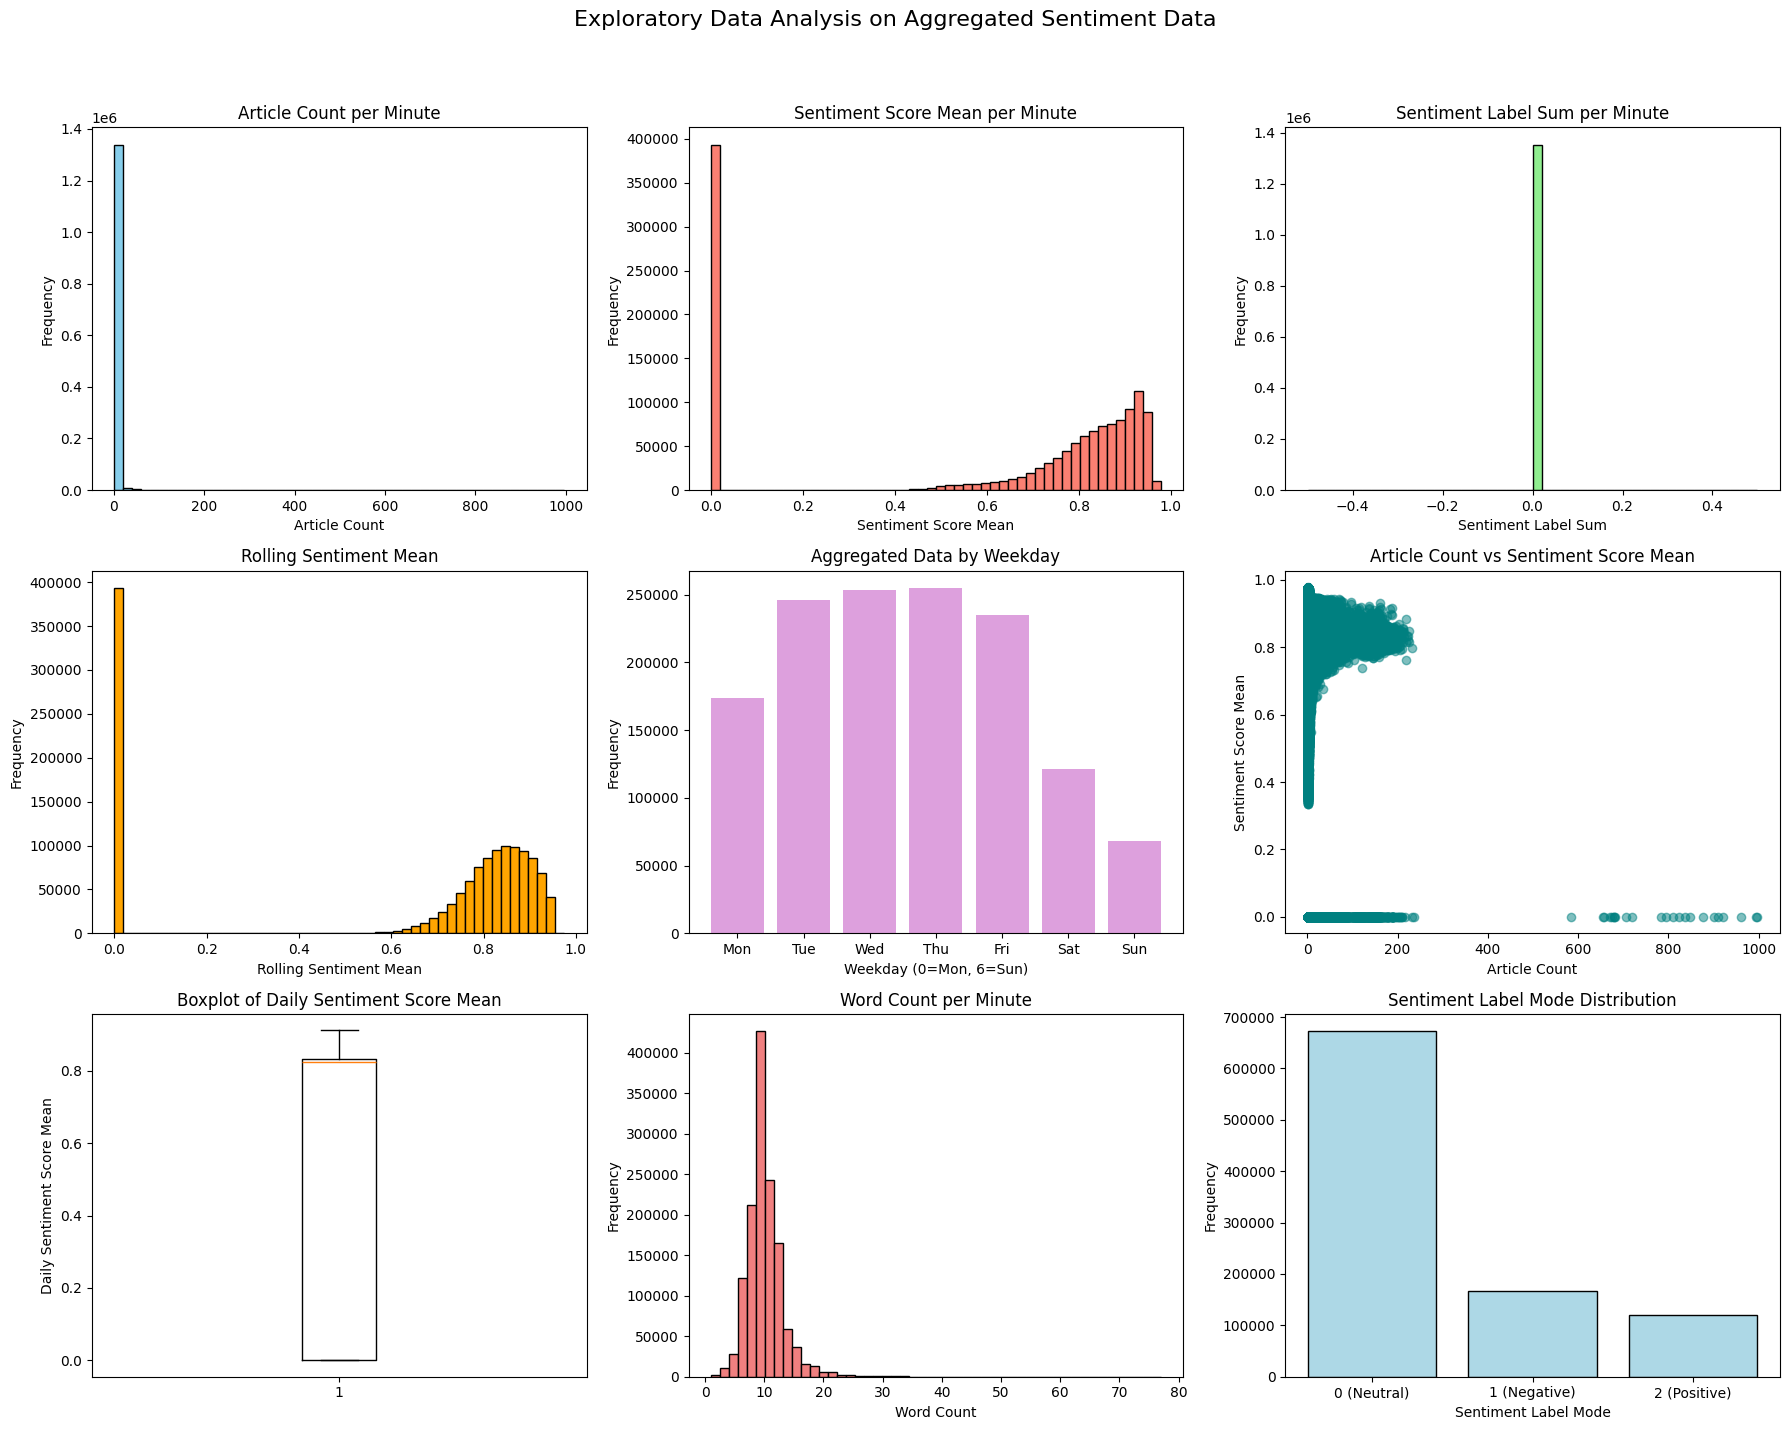

In [ ]:
import matplotlib.pyplot as plt

def plot_final_df_distributions(final_df):
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Exploratory Data Analysis on Aggregated Sentiment Data', fontsize=16)

    # Plot 1: Distribution of article_count per minute
    axes[0, 0].hist(final_df['article_count'], bins=50, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Article Count per Minute')
    axes[0, 0].set_xlabel('Article Count')
    axes[0, 0].set_ylabel('Frequency')

    # Plot 2: Distribution of sentiment_score_mean per minute
    axes[0, 1].hist(final_df['sentiment_score_mean'], bins=50, color='salmon', edgecolor='black')
    axes[0, 1].set_title('Sentiment Score Mean per Minute')
    axes[0, 1].set_xlabel('Sentiment Score Mean')
    axes[0, 1].set_ylabel('Frequency')

    # Plot 3: Distribution of sentiment_label_sum per minute
    axes[0, 2].hist(final_df['sentiment_label_sum'], bins=50, color='lightgreen', edgecolor='black')
    axes[0, 2].set_title('Sentiment Label Sum per Minute')
    axes[0, 2].set_xlabel('Sentiment Label Sum')
    axes[0, 2].set_ylabel('Frequency')

    # Plot 4: Distribution of rolling_sentiment_mean
    axes[1, 0].hist(final_df['rolling_sentiment_mean'], bins=50, color='orange', edgecolor='black')
    axes[1, 0].set_title('Rolling Sentiment Mean')
    axes[1, 0].set_xlabel('Rolling Sentiment Mean')
    axes[1, 0].set_ylabel('Frequency')

    # Plot 5: Weekday distribution (bar chart)
    weekday_counts = final_df['weekday'].value_counts().sort_index()
    axes[1, 1].bar(weekday_counts.index, weekday_counts.values, color='plum')
    axes[1, 1].set_title('Aggregated Data by Weekday')
    axes[1, 1].set_xlabel('Weekday (0=Mon, 6=Sun)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_xticks(ticks=range(7))
    axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Plot 6: Scatter - Article Count vs Sentiment Score Mean
    axes[1, 2].scatter(final_df['article_count'], final_df['sentiment_score_mean'], alpha=0.5, color='teal')
    axes[1, 2].set_title('Article Count vs Sentiment Score Mean')
    axes[1, 2].set_xlabel('Article Count')
    axes[1, 2].set_ylabel('Sentiment Score Mean')

    # Plot 7: Boxplot of daily_sent_score_mean
    axes[2, 0].boxplot(final_df['daily_sent_score_mean'], vert=True)
    axes[2, 0].set_title('Boxplot of Daily Sentiment Score Mean')
    axes[2, 0].set_ylabel('Daily Sentiment Score Mean')

    # Remove unused axes
    axes[2, 1].hist(final_df['word_count_mean'], bins=50, color='lightcoral', edgecolor='black')
    axes[2, 1].set_title('Word Count per Minute')
    axes[2, 1].set_xlabel('Word Count')
    axes[2, 1].set_ylabel('Frequency')

    # Sentiment Label Mode Distribution (numeric x-axis)
    mode_counts = final_df['sentiment_label_mode_num'].value_counts().sort_index()
    axes[2, 2].bar(mode_counts.index, mode_counts.values, color='lightblue', edgecolor='black')
    axes[2, 2].set_title('Sentiment Label Mode Distribution')
    axes[2, 2].set_xlabel('Sentiment Label Mode')
    axes[2, 2].set_ylabel('Frequency')
    axes[2, 2].set_xticks(list(sentiment_mode_map.values()))
    axes[2, 2].set_xticklabels([f"{v} ({k.capitalize()})" for k, v in sentiment_mode_map.items()])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_final_df_distributions(final_df)

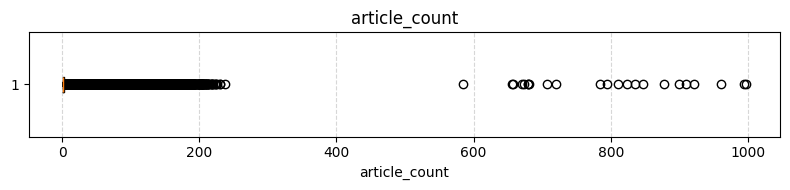

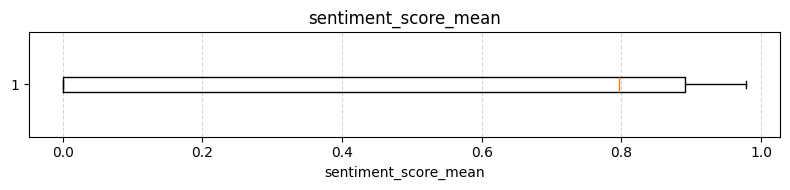

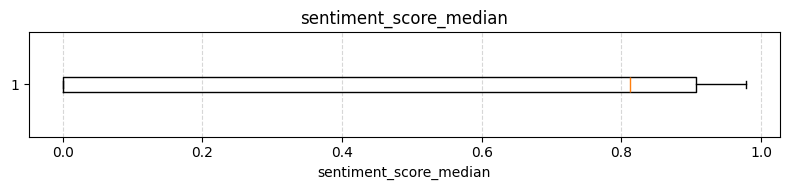

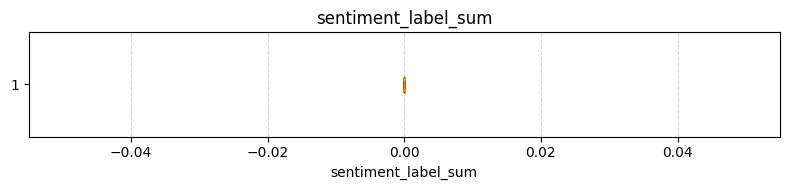

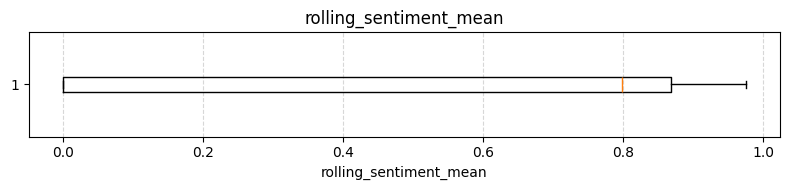

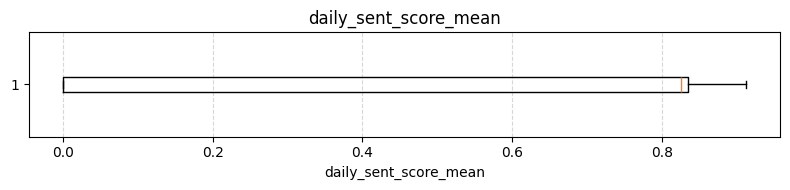

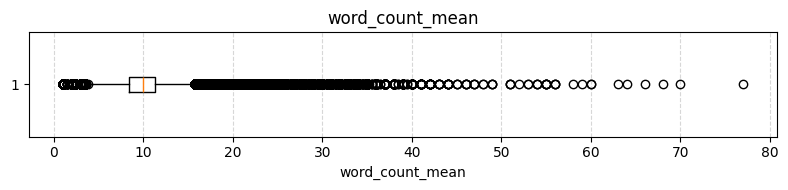

In [83]:
import matplotlib.pyplot as plt

# Function to detect outliers using the IQR method
def detect_outliers(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

# List of columns to check for outliers
cols_to_check = [
    'article_count', 
    'sentiment_score_mean', 
    'sentiment_score_median', 
    'sentiment_label_sum', 
    'rolling_sentiment_mean',
    'daily_sent_score_mean',
    'word_count_mean'
]

def plot_boxplots(df, cols, figsize=(8, 2)):
    for col in cols:
        plt.figure(figsize=figsize)
        plt.boxplot(df[col], vert=False)
        plt.title(f'{col}')
        plt.xlabel(col)
        plt.grid(True, axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

plot_boxplots(final_df, cols_to_check)


We initially were thinking of removing the outliers, but decided to leave them as is. They seem to be natural variations.

In [ ]:
final_df = final_df.set_index('id')

In [ ]:
agg_news_features_df = final_df

In [9]:
agg_news_parquet_path = os.path.join(PROCESSED_DATA, "aggregated_news_with_features.parquet")
agg_news_features_df.to_parquet(agg_news_parquet_path, index=True, compression="snappy")


In [10]:
agg_news_features_df = pd.read_parquet(agg_news_parquet_path)


In [14]:
agg_news_features_df.columns

Index(['id', 'hour', 'minute_of_hour', 'weekday', 'article_count',
       'sentiment_score_mean', 'sentiment_score_median', 'char_count_mean',
       'char_count_median', 'word_count_mean', 'word_count_median',
       'rolling_sentiment_mean', 'daily_article_count',
       'daily_sent_score_mean', 'sentiment_label_mode_num'],
      dtype='object')

In [ ]:
agg_news_features_df.index = pd.to_datetime(
    agg_news_features_df.index, format="%Y%m%d%H%M", errors='coerce'
)

In [16]:
agg_news_features_df['datetime'] = pd.to_datetime(agg_news_features_df['id'], format="%Y%m%d%H%M", errors='coerce')
agg_news_features_df = agg_news_features_df.set_index('datetime')

In [17]:
agg_news_features_df = agg_news_features_df.sort_index()


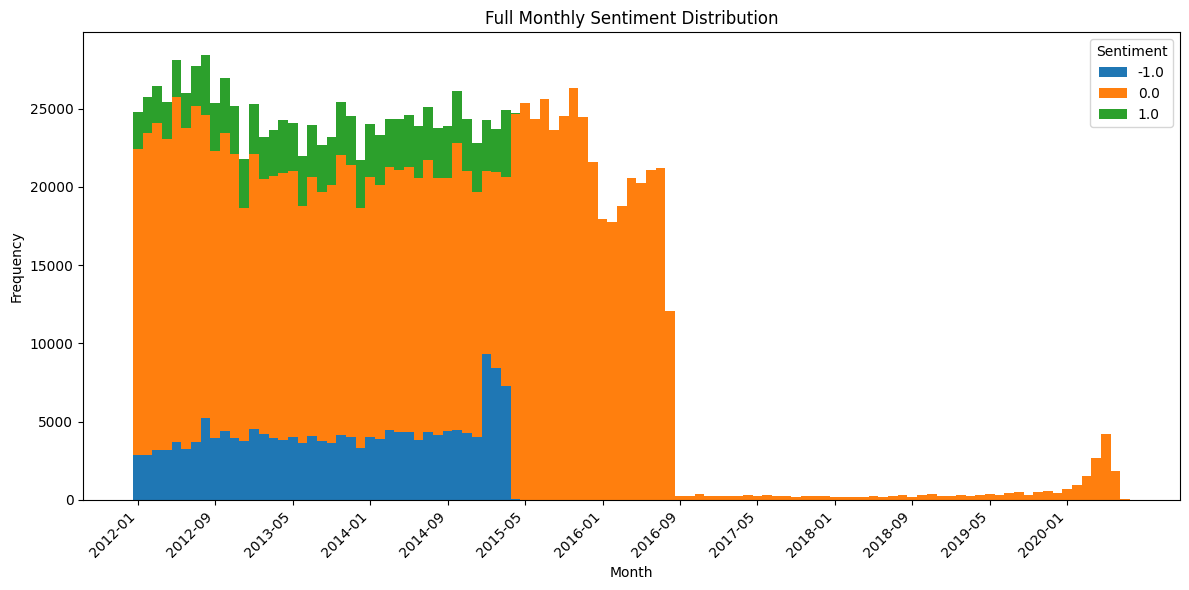

In [ ]:
def plot_monthly_sentiment_distribution(monthly_df, title="Monthly Sentiment Distribution"):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(monthly_df.index))
    bottom = np.zeros(len(x))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

    for i, col in enumerate(monthly_df.columns):
        vals = monthly_df[col].values
        ax.bar(x, vals, bottom=bottom, color=colors[i % len(colors)], width=1.0, label=str(col))
        bottom += vals

    xtick_spacing = max(1, len(x) // 12) 
    xticks = x[::xtick_spacing]
    xtick_labels = [ts.strftime('%Y-%m') for ts in monthly_df.index[::xtick_spacing]]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

    ax.set_title(title)
    ax.set_xlabel("Month")
    ax.set_ylabel("Frequency")
    ax.legend(title="Sentiment")
    plt.tight_layout()
    plt.show()

# Plot for the full dataset
plot_monthly_sentiment_distribution(monthly_counts, title="Full Monthly Sentiment Distribution")


Lower bound: 2012-01-31 00:00:00
Upper bound: 2015-03-31 00:00:00


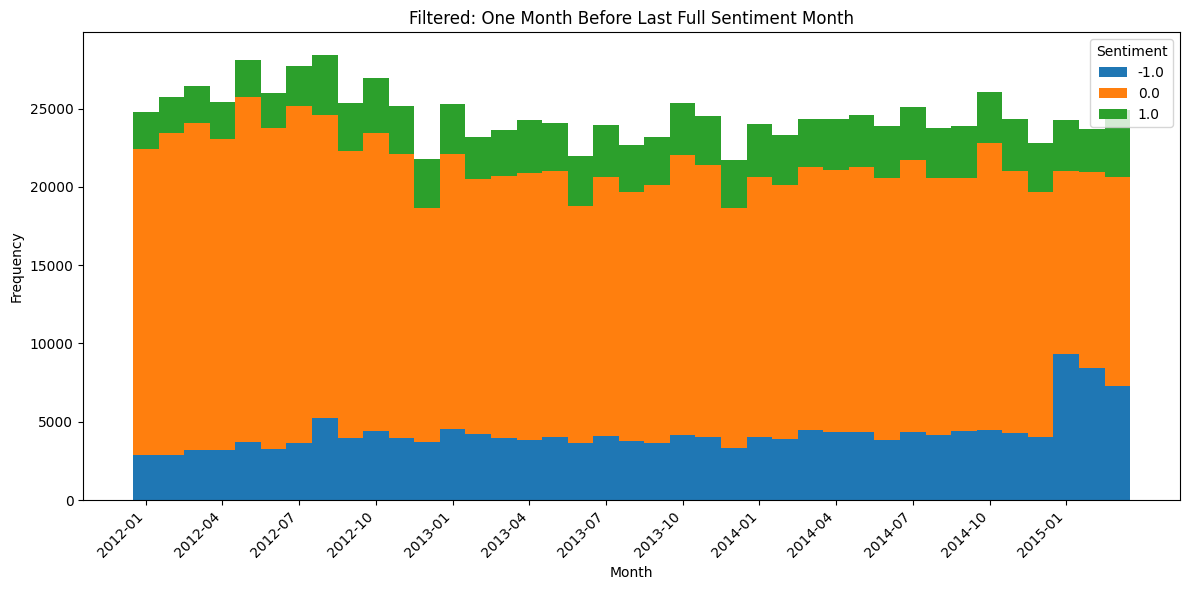

In [30]:
required_labels = [-1.0, 0.0, 1.0]
has_all_three = (monthly_counts[required_labels] > 0).all(axis=1)
last_valid_month = monthly_counts[has_all_three].index[-2]
monthly_counts_filtered = monthly_counts.loc[:last_valid_month]

lower_bound = monthly_counts_filtered.index[0]
upper_bound = monthly_counts_filtered.index[-1]

print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)

plot_monthly_sentiment_distribution(
    monthly_counts_filtered,
    title="Filtered: One Month Before Last Full Sentiment Month"
)
